In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from bench_isolation_forest_parallel_predict import test_n_rows, test_n_trees

In [2]:
def plot_speed_up(speed_up_values, x_label, y_label, legend_base):
    ax = sns.heatmap(speed_up_values)
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.show()
    
    for i in range(speed_up_values.shape[0]):
        label_name = "{}={}".format(legend_base, speed_up_values.index.tolist()[i])
        plt.plot(np.arange(0, speed_up_values.shape[1]), 
                 speed_up_values.values[i, :], 
                 label=label_name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(np.arange(0, speed_up_values.shape[1]), 
               speed_up_values.columns.tolist())
    plt.legend()
    plt.show()

# Benchmark

In this notebook we are benchmarking parallelizing Isolation Forest during prediction time. At the moment, prediction runs single-threaded.

Parallelization is done at the trees level. In a previous implementation we ran each tree in its own thread. But, in this version, after specifying the number of parallel jobs, we divide the trees into batches of trees. In this way, we avoid creating a thread per tree, and instead we create just the necessary number of parallel threads. In principle, this should save some time for thread creation and management, compared with the previous approach.

This notebook is the **second version** of this benchmark and results should be compared with the first notebook. The first version is found in: https://github.com/TechhubLisbon/scikit-learn/blob/iforest-parallel-predict-benchmark/benchmarks/bench_isolation_forest_parallel_predict.ipynb

We will evaluate its impact on runtime in two scenarios:
- Fix the number of trees, and vary the amount of data and number of parallel threads.
- Fix the amount of data, and vary the number of trees and number of parallel threads.

**Methodology**
- The used data is randomly generated. The seed is fixed in each test, so we obtain reproducible results.
- We first obtain the runtimes from the current Isolation Forest implementation ($t_s$). For this test, we also vary the number of parallel threads (although it runs single-threaded during prediction, we ran it anyway to get the baseline runtimes).
- Then, we vary the variables under study and obtain the running times ($t_p$). Finally, we obtain the speed up values as $\frac{t_s}{t_p}$. Speed up > 1 means that the parallel method was faster than the single threaded one. Values in ]0, 1] means that the parallel method was slower or similar with the single threaded one.
- Check the companion bench_isolation_forest_parallel_predict.py for code.

### Scenario 1 - evaluate performance with the amount of data

In this test, we fixed the number of trees to 100, and we varied the amount of data in an exponential increasing fashion. We evaluate the run times and speed up obtained by increasing the number of parallel threads.

1) The first table shows the runtimes of the current implementation, which is single-threaded, during prediction. We can see that run times are quite similar as we increase the number of parallel threads for the same amount of data. Obviously, the runtime increases with the amount of prediction data.

2) The second table shows the runtimes with the Isolation Forest in the PR with parallel threads during prediction.

3) The third table shows the obtained speed ups. We can see, as in the previous implementation, that for small amounts of data the parallel approach is slower than the current single-threaded one. But for larger data it is consistently faster.

**4)** Comparing with the previous parallel version, we observe that for smaller amounts of data this version is faster than the previous one. This possibly confirms that there was some overhead related with the thread management with some weight on the running times. Interestingly, when we increase the amount of data, the previous approach is slightly faster. This can be due to chunks of threads finishing faster than others. Still, if we compare the second table of this notebook and the first version, we can see that the difference between the actual runtimes is just a few seconds, which is not so significant.

**Note:** in the heat map plot, the label of the y axis should be read as n_samples, and the colorbar represents the speed up. Note that the largest amount of data and number of parallel threads are found in the bottom right corner.

	Current prediction execution time:


,1,2,4,6,8,10,12
1000,0.082536,0.085486,0.092674,0.089065,0.082460,0.079268,0.080839
10000,0.475456,0.455466,0.514718,0.507724,0.500804,0.469793,0.449014
100000,5.603862,5.522148,5.610925,5.614777,5.659807,5.666504,5.625864
1000000,75.011659,77.100918,76.286165,75.975792,76.051207,76.091218,76.090875


	Pull request prediction execution time:


,1,2,4,6,8,10,12
1000,0.079064,0.102969,0.123657,0.124174,0.126400,0.105303,0.125211
10000,0.482306,0.331946,0.307466,0.287288,0.310671,0.309841,0.313286
100000,5.617817,3.551313,2.675623,2.584458,2.457609,2.353779,2.336641
1000000,74.891965,46.070760,29.122475,24.341286,23.197068,21.742351,21.455191


	Speed up:


,1,2,4,6,8,10,12
1000,1.043917,0.830207,0.749445,0.717257,0.652377,0.752763,0.645620
10000,0.985796,1.372110,1.674061,1.767300,1.612009,1.516236,1.433238
100000,0.997516,1.554960,2.097054,2.172516,2.302973,2.407407,2.407672
1000000,1.001598,1.673533,2.619495,3.121273,3.278484,3.499678,3.546502


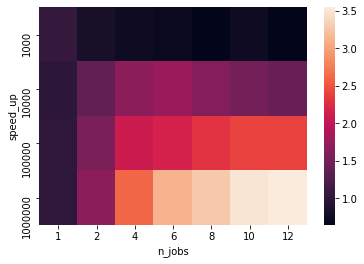

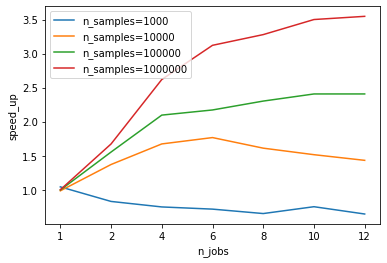

CPU times: user 4h 10min 25s, sys: 1h 42min 24s, total: 5h 52min 50s
Wall time: 2h 9min


In [3]:
%%time

n_samples_list = [1000, 10000, 100000, 1000000]
n_jobs_list = [1, 2, 4, 6, 8, 10, 12]
n_features = 30
repetitions = 5
n_trees = 100

results_sklearn_iforest_n_samples, results_parallel_iforest_n_samples, speed_up_n_samples = \
    test_n_rows(n_samples_list=n_samples_list, n_jobs_list=n_jobs_list, 
                n_features=n_features, repetitions=repetitions,
                n_trees=n_trees)

print("\tCurrent prediction execution time:")
display(results_sklearn_iforest_n_samples)
print("\tPull request prediction execution time:")
display(results_parallel_iforest_n_samples)
print("\tSpeed up:")
display(speed_up_n_samples)

plot_speed_up(speed_up_n_samples, x_label="n_jobs", y_label="speed_up",
              legend_base="n_samples")

### Scenario 2 - evaluate performance with the number of trees

In this test, we fixed the number of samples to 10000, and we varied the number of trees in an increasing fashion. We evaluate the run times and speed up obtained by increasing the number of parallel threads.

1) The first table shows the runtimes of the current implementation, which is single-threaded, during prediction. We can see that run times are quite similar as we increase the n_jobs parameters for the same number of trees (as expected, since it is single threaded). Of course, the runtime increases with the number of trees.

2) The second table shows the runtimes with the Isolation Forest in the PR with parallel threads during prediction.

3) The third table shows the obtained speed ups. We can see improvements even the smallest number of trees (50). Still, we obtained better runtime improvements as we increase the number of trees. From the line plots, it appears that if we keep increasing the number of trees, we will obtain smaller, but improved runtime speed ups as compared with single-threaded predictions.

**4)** Comparing with the previous parallel implementation (first version of this notebook) we observe that the current method achieves better runtimes for 2 threads only. This is not so surprising, as in the previous results we saw that the first approach was slightly faster with larger data. Yet, again, the difference in actual runtimes is less than 1 second between both approaches.

**Note:** in the heat map plot, the label of the y axis should be read as n_jobs, and the colorbar represents the speed up. Note that the largest number of trees and parallel threads are found in the bottom right corner.

	Current prediction execution time:


,1,2,4,6,8,10,12
50,2.721825,2.807499,2.795234,2.855817,2.817035,2.840690,2.833656
100,5.509348,5.559117,5.621079,5.582452,5.697712,5.568042,5.611709
150,8.199366,8.333245,8.278037,8.526845,8.403105,8.401647,8.342475
200,10.937622,11.097518,11.162097,11.022712,11.253684,11.216813,11.203525
250,13.783871,13.968841,13.924724,14.199335,13.978963,14.036686,14.023083
300,16.435211,16.727515,16.704100,16.885088,16.976162,16.708011,16.964844


	Pull request prediction execution time:


,1,2,4,6,8,10,12
50,2.741388,1.893862,1.451991,1.342387,1.294601,1.185744,1.219025
100,5.491220,3.574617,2.797950,2.618311,2.458470,2.322973,2.312724
150,8.214921,5.295664,4.017893,3.800297,3.603217,3.447477,3.419659
200,10.861147,7.048480,5.204225,5.109261,4.788160,4.601165,4.515490
250,13.776362,8.798611,6.544741,6.060697,5.828610,5.725526,5.622103
300,16.335293,10.461209,7.779909,6.905176,7.132298,6.865305,6.707163


	Speed up:


,1,2,4,6,8,10,12
50,0.992864,1.482420,1.925104,2.127417,2.175988,2.395703,2.324526
100,1.003301,1.555164,2.008999,2.132082,2.317584,2.396946,2.426450
150,0.998107,1.573598,2.060293,2.243731,2.332112,2.437042,2.439563
200,1.007041,1.574456,2.144814,2.157399,2.350315,2.437820,2.481132
250,1.000545,1.587619,2.127620,2.342855,2.398336,2.451598,2.494277
300,1.006117,1.599004,2.147082,2.445280,2.380181,2.433688,2.529362


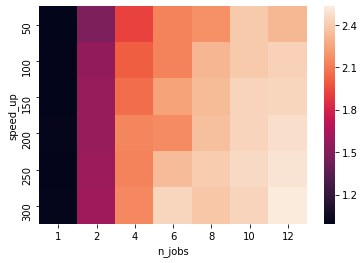

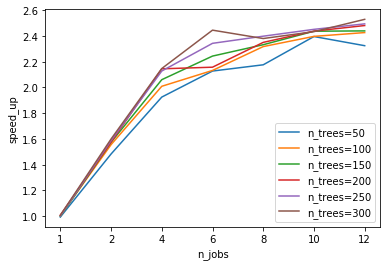

CPU times: user 3h 47min 30s, sys: 40min 5s, total: 4h 27min 35s
Wall time: 1h 42min 14s


In [4]:
%%time

n_trees_list = [50, 100, 150, 200, 250, 300]
n_jobs_list = [1, 2, 4, 6, 8, 10, 12]
n_features = 30
repetitions = 5
n_samples = 100000

results_sklearn_iforest_n_trees, results_parallel_iforest_n_trees, speed_up_n_trees = \
    test_n_trees(n_trees_list=n_trees_list, n_jobs_list=n_jobs_list, 
                 n_features=n_features, repetitions=repetitions,
                 n_samples=n_samples)

print("\tCurrent prediction execution time:")
display(results_sklearn_iforest_n_trees)
print("\tPull request prediction execution time:")
display(results_parallel_iforest_n_trees)
print("\tSpeed up:")
display(speed_up_n_trees)

plot_speed_up(speed_up_n_trees, x_label="n_jobs", y_label="speed_up",
              legend_base="n_trees")

#### Final remarks 

The results in this benchmark show that Isolation Forest's prediction runtime benefits from doing it with parallel threads. If the amount of data is very small, it is slower, which is expected, as there is some overhead.

We evaluated the effect of increasing the amount of test data and number of trees separately. However, we could expect to obtain even higher speed ups if we increase both the amount of data and the number of parallel threads. This is actually what we got with our private data.

When the amount of data is small (1000 samples), running prediction in parallel is slower than in parallel. However, the runtimes of the parallel method was < 120 ms, which is still relatively fast. To conclude, parallel prediction can bring benefits when we have > 1000 points and improves with the number of trees. This is important in applications with more data at prediction time, but also during hyper-parameter search, when we need to run several trials.

**From this version:** we observed that dividing the trees into chunks instead of running each one in its own parallel thread can bring some benefits, especially when the prediction data is small. Still, when we increase the amount of data, we can see that it is slower than the previous parallelization method, but the actual difference is around a couple of seconds. Therefore, the current implementation may be a better compromise for applications with small and larger data.